In [1]:
import gym
import random
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rlutils
from tqdm import tqdm

In [2]:
class PolicyNet(nn.Module):
    def __init__(self,state_dim, hidden_dim, action_dim, action_bound) -> None:
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x)) * self.action_bound


class QValueNet(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim) -> None:
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)  # 拼接状态和动作
        x = F.relu(self.fc1(cat))
        return self.fc2(x)


class TwoLayerFC(nn.Module):
    def __init__(self, num_in, num_out, hidden_dim, activation=F.relu, out_fn=lambda x:x) -> None:
        super().__init__()
        self.fc1 = nn.Linear(num_in, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_out)

        self.activation = activation
        self.out_fn = out_fn

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.out_fn(self.fc3(x))
        return x
        




In [22]:
'''DDPG算法'''
class DDPG:
    def __init__(
        self, 
        num_in_actor, num_out_actor, 
        num_in_critic, 
        hidden_dim, 
        discrete, 
        action_bound, 
        sigma, 
        actor_lr, critic_lr, 
        tau, 
        gamma, 
        device) -> None:
        out_fn = (lambda x: x) if discrete else (lambda x: torch.tanh(x) * action_bound)
        self.actor = TwoLayerFC(num_in_actor, num_out_actor, hidden_dim, activation=F.relu, out_fn=out_fn).to(device)
        self.target_actor = TwoLayerFC(num_in_actor, num_out_actor, hidden_dim, activation=F.relu, out_fn=out_fn).to(device)
        self.critic = TwoLayerFC(num_in_critic, 1, hidden_dim).to(device)
        self.target_critic = TwoLayerFC(num_in_critic, 1, hidden_dim).to(device)
        # 初始化目标价值网络并设置和价值网络相同的参数
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化策略网络并设置和策略网络相同的参数
        self.target_actor.load_state_dict(self.actor.state_dict())

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差，均值直接设置为0
        self.tau = tau  # 目标网络软更新参数
        self.action_dim = num_out_actor  
        self.action_bound = action_bound  # 环境可以接受的动作最大值
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state).item()
        # 给动作添加噪声，增加探索
        action = action + self.sigma * np.random.randn(self.action_dim)
        return action

    def soft_update(self, net, target_net):
        for para_target, param in zip(target_net.parameters(), net.parameters()):
            para_target.data.copy_(para_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(torch.cat([next_states, self.target_actor(next_states)], dim=1))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        critic_loss = torch.mean(F.mse_loss(
            #  MSE损失函数
            self.critic(torch.cat([states, actions], dim=1)), q_targets
        ))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = - torch.mean(self.critic(
            # 策略网络是为了使得Q值最大化
            torch.cat([states, self.actor(states)], dim=1)
        ))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor, self.target_actor)
        self.soft_update(self.critic, self.target_critic)
        
        

In [29]:
actor_lr = 5e-4
critic_lr = 5e-3
num_episodes = 200
hidden_dim = 64
gamma = 0.98
tau = 0.005  # 软更新参数
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.001  # 高斯噪声标准差
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

env_name = 'Pendulum-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rlutils.ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
agent = DDPG(state_dim, action_dim, state_dim + action_dim, hidden_dim, False, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device)

return_list = rlutils.train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)


Iteration 9: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s, episode=200, return=-194.915]


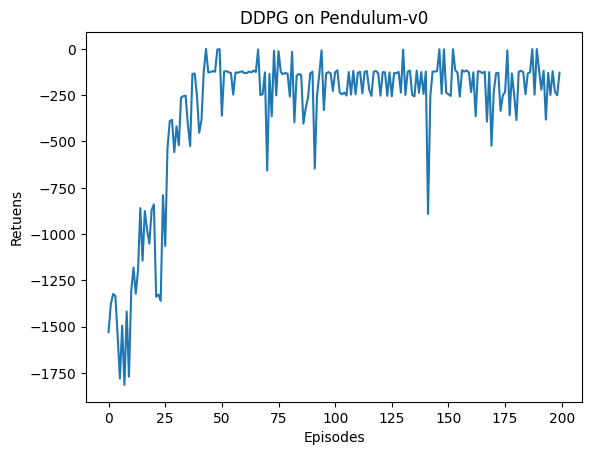

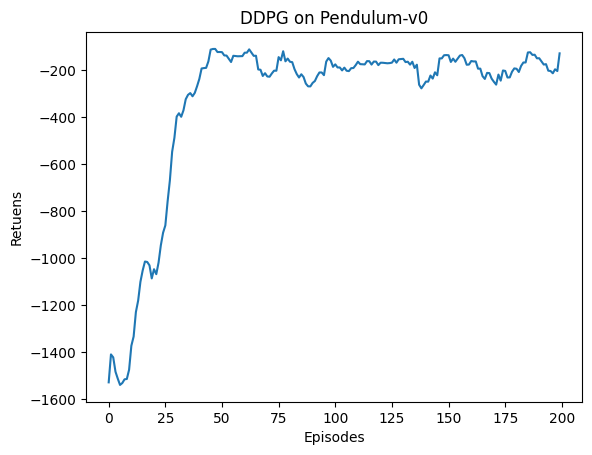

In [30]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Retuens')
plt.title('DDPG on {}'.format(env_name))
plt.show()

mv_return= rlutils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Retuens')
plt.title('DDPG on {}'.format(env_name))
plt.show()


In [48]:
state = env.reset()
total_reward = 0
done = False
while not done:
    env.render()
    action = agent.take_action(state)
    next_state, reward, done, _ = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.close()

-123.642543719325
